# **Sentimen Analisis Review Tokopedia di Playstore**


In [1]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import os
import re
import string

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import download as nltk_unduh

nltk_unduh('stopwords')
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,  Dense,  GRU, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping,  ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import pickle
from keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hilmi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **LOADING DATASET**

In [2]:
df_data = pd.read_csv('tokopedia_review_all.csv')

In [3]:
df_data.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,283117c8-48c2-4377-a547-9226f02a0b1f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,mantappp,5,0,3.309.0,2025-04-24 18:29:34,"Hi Toppers, terima kasih untuk rating dan ulas...",2025-04-24 19:07:11,3.309.0
1,f3fb5844-8b7d-404d-8284-ec81bc20d45a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,lag mulu,1,0,3.309.0,2025-04-24 18:21:51,"Toppers, mohon maaf atas kendala yang kamu ala...",2025-04-24 18:40:10,3.309.0
2,2ed93ca5-5769-4dec-81ff-ee674f68566e,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Alhamdulillah barang nya bagus, dan kirimannya...",2,0,3.306.0,2025-04-24 18:20:38,"Halo Toppers, terima kasih atas rating yang ka...",2025-04-24 18:47:04,3.306.0
3,36234a33-8c85-43f2-b0ed-de3fb27813a9,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Saya merasa dipermainkan setelah melakukan pem...,1,0,3.306.0,2025-04-24 18:20:06,"Halo Toppers, terima kasih atas rating yang ka...",2025-04-24 18:47:06,3.306.0
4,d0cf0595-5e8c-4b4f-993a-f802c5549698,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,jangan belanja di tokoed lagi ges belanjaa gw ...,1,0,NaN,2025-04-24 18:17:32,"Halo Toppers, terima kasih atas rating yang ka...",2025-04-24 18:47:08,NaN


## **EXPLORATORY DATA ANALYSIS**

In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              50000 non-null  object
 1   userName              50000 non-null  object
 2   userImage             50000 non-null  object
 3   content               49999 non-null  object
 4   score                 50000 non-null  int64 
 5   thumbsUpCount         50000 non-null  int64 
 6   reviewCreatedVersion  40790 non-null  object
 7   at                    50000 non-null  object
 8   replyContent          49996 non-null  object
 9   repliedAt             49996 non-null  object
 10  appVersion            40790 non-null  object
dtypes: int64(2), object(9)
memory usage: 4.2+ MB


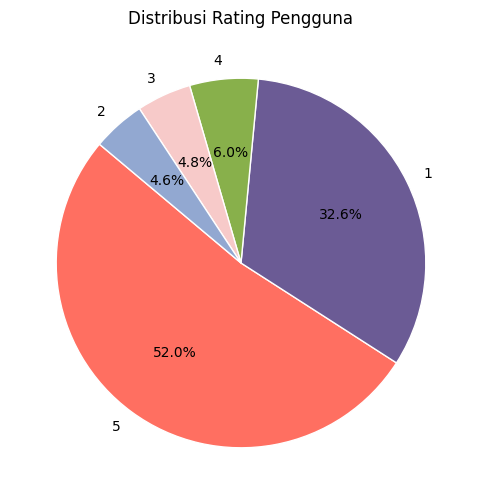

score
5    26012
1    16293
4     2995
3     2389
2     2311
Name: count, dtype: int64


In [5]:
score_counts = df_data['score'].value_counts()
colors = ['#FF6F61', '#6B5B95', '#88B04B', '#F7CAC9', '#92A8D1']
plt.figure(figsize=(6, 6))
plt.pie(score_counts, labels=score_counts.index, colors=colors, autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'white'})
plt.title("Distribusi Rating Pengguna")
plt.show()

print(score_counts)

## **TEXT PREPOCESSING**

In [6]:

df_data = df_data[['content','score']]

In [7]:
df_data['content'] = (
    df_data['content']          # ambil kolom
    .astype(str)                # paksa ke string
    .replace('nan', '')         # jika hasil konversi 'nan' string
    .replace('None', '')        # optional
)

In [8]:
# membersihkan text dari hal seperti hastag link , angka dll
def cleaningText(text):
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

def casefoldingText(text):
    return text.lower()

def tokenizingText(text):
    return word_tokenize(text)

# menghapus stopword indo dan bing 
def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    stopwordtambahan=['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"]
    all_stopwords = listStopwords.union(listStopwords1).union(stopwordtambahan)
    filtered = [kata for kata in text if kata not in all_stopwords]
    
    text = filtered
    return text


# fungsi untuk menggabungkan token menjadi kalimat kembali
def toSentence(tokens):
    return ' '.join(tokens)

In [9]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}


In [10]:
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [11]:
# membersihkan teks dan menyimpannya di kolom 'text_clean'
df_data['clean_text'] = df_data['content'].apply(cleaningText)

# mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
df_data['clean_text'] = df_data['clean_text'].apply(casefoldingText)

# mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
df_data['text_slangwords'] = df_data['clean_text'].apply(fix_slangwords)

# memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
df_data['text_tokenizing'] = df_data['clean_text'].apply(tokenizingText)

# menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
df_data['text_stopword'] = df_data['text_tokenizing'].apply(filteringText)

# menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
df_data['text_akhir'] = df_data['text_stopword'].apply(toSentence)

## **PELABELAN**

In [12]:

def baca_lexikon_lokal(filepath):
    # Gabungkan direktori notebook dengan path relatif
    path= os.path.dirname(os.path.abspath("__file__"))+filepath
    
    # Membaca file teks
    with open(path, mode='r', encoding='utf-8') as file:
        # Membaca setiap baris, stripping spasi dan menambahkannya ke dalam set
        lexikon = set(kata.strip() for kata in file.readlines() if kata.strip())
        
    return lexikon

# Path ke file lokal
file_positif = "\\positive.txt"
file_negatif = "\\negative.txt"

lexikon_positif = baca_lexikon_lokal(file_positif)
lexikon_negatif = baca_lexikon_lokal(file_negatif)

print(f"Jumlah kata positif: {len(lexikon_positif)}")
print(f"Jumlah kata negatif: {len(lexikon_negatif)}")

Jumlah kata positif: 1182
Jumlah kata negatif: 2402


In [13]:
def sentimen_analisis(text):
    score = 0
    for word in text:

        if (word in lexikon_positif):
            score = score + 1
        if (word in lexikon_negatif):
            score = score -1

    polarity=''
    if (score > 0):
        polarity = 'positif'
    elif (score < 0):
        polarity = 'negatif'
    else:
        polarity='netral'

    return score, polarity


hasil_sentimen = df_data['text_stopword'].apply(sentimen_analisis)
hasil_sentimen = list(zip(*hasil_sentimen))
df_data['sentimen_skor'] = hasil_sentimen[0]
df_data['sentimen'] = hasil_sentimen[1]
print(df_data['sentimen'].value_counts())

sentimen
netral     26735
positif    14699
negatif     8566
Name: count, dtype: int64


# **DATA UNDERSTANDING**

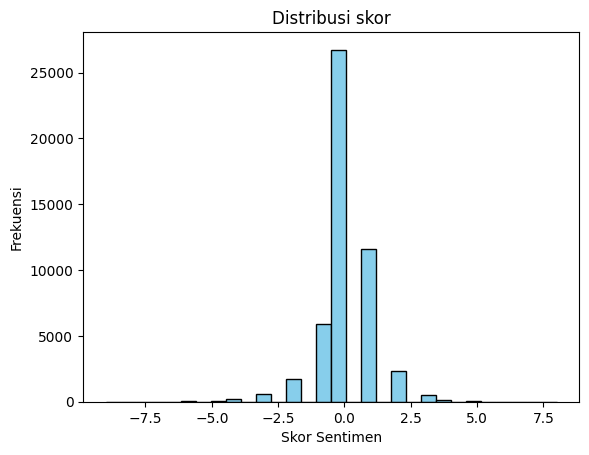

In [14]:
plt.hist(df_data['sentimen_skor'], bins=30, color='skyblue', edgecolor='black')


plt.xlabel('Skor Sentimen')
plt.ylabel('Frekuensi')
plt.title('Distribusi skor')

# Show the plot
plt.show()

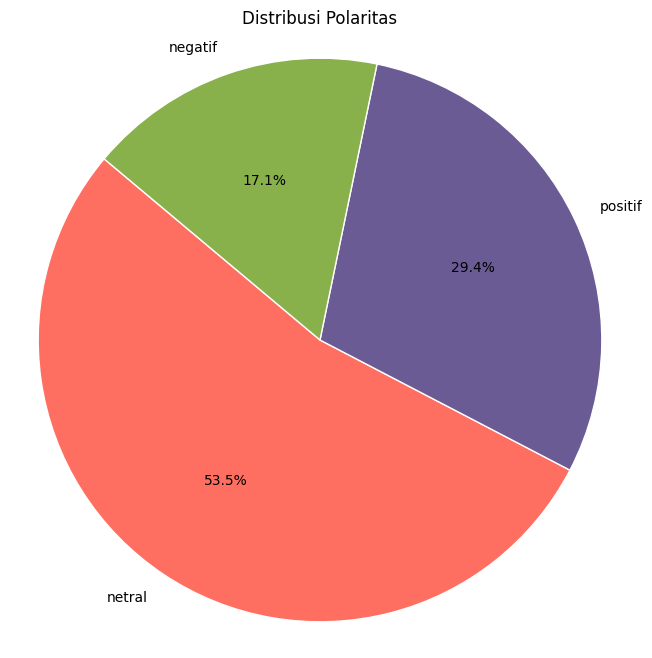

In [15]:
# hitung jumlah masing-masing kategori
jumlah_sentimen = df_data['sentimen'].value_counts()
colors = ['#FF6F61', '#6B5B95', '#88B04B']
plt.figure(figsize=(8, 8))
plt.pie(jumlah_sentimen,
        labels=jumlah_sentimen.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        wedgeprops={'edgecolor': 'white'})
plt.title('Distribusi Polaritas')
plt.axis('equal')
plt.show()


# **WORD CLOUD**

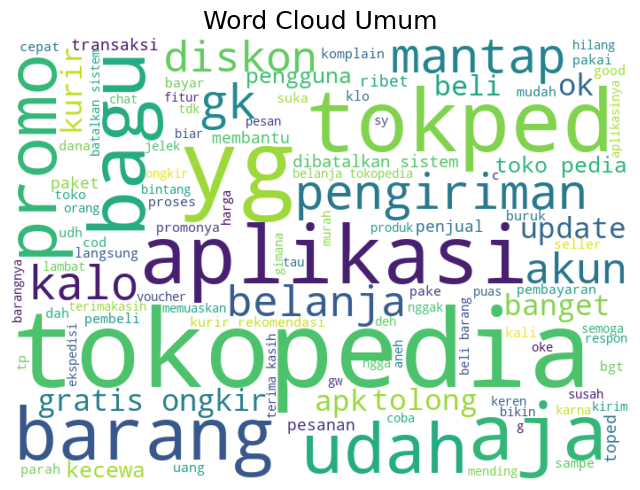

In [16]:
def wordcloud(data, judul):
    list_kata = ''
    for kalimat in data['text_stopword']:
        for kata in kalimat:
            list_kata += ' ' + kata

    wordcloud = WordCloud(width=700, height=500, background_color='white', min_font_size=12).generate(list_kata)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(judul, fontsize=18)
    ax.grid(False)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    plt.show()

# wordcloud umum
wordcloud(df_data, 'Word Cloud Umum')

In [17]:
df_data.head()

,content,score,clean_text,text_slangwords,text_tokenizing,text_stopword,text_akhir,sentimen_skor,sentimen
0,mantappp,5,mantappp,mantappp,[mantappp],[mantappp],mantappp,0,netral
1,lag mulu,1,lag mulu,lag melulu,"[lag, mulu]","[lag, mulu]",lag mulu,0,netral
2,"Alhamdulillah barang nya bagus, dan kirimannya...",2,alhamdulillah barang nya bagus dan kirimannya ...,alhamdulillah barang nya bagus dan kirimannya ...,"[alhamdulillah, barang, nya, bagus, dan, kirim...","[alhamdulillah, barang, bagus, kirimannya, cep...",alhamdulillah barang bagus kirimannya cepat se...,4,positif
3,Saya merasa dipermainkan setelah melakukan pem...,1,saya merasa dipermainkan setelah melakukan pem...,saya merasa dipermainkan setelah melakukan pem...,"[saya, merasa, dipermainkan, setelah, melakuka...","[dipermainkan, pembayaran, virtual, bank, pili...",dipermainkan pembayaran virtual bank pilih sel...,2,positif
4,jangan belanja di tokoed lagi ges belanjaa gw ...,1,jangan belanja di tokoed lagi ges belanjaa gw ...,jangan belanja di tokoed lagi ges belanjaa say...,"[jangan, belanja, di, tokoed, lagi, ges, belan...","[belanja, tokoed, ges, belanjaa, gw, tiba², ba...",belanja tokoed ges belanjaa gw tiba² batalkan ...,0,netral


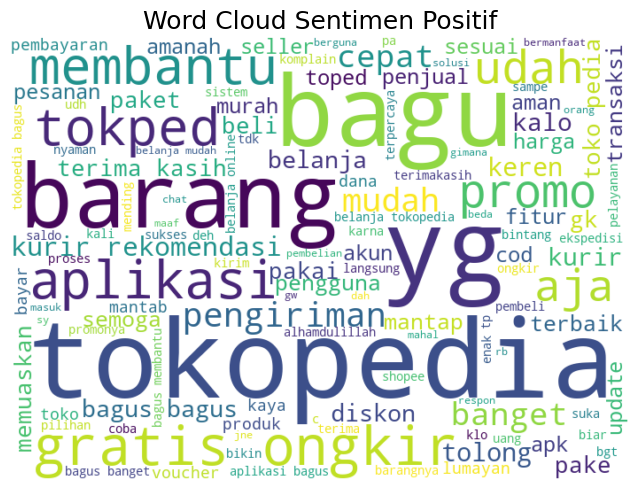

In [18]:
# wordcloud positif
wordcloud(df_data[df_data['sentimen'] == 'positif'], 'Word Cloud Sentimen Positif')

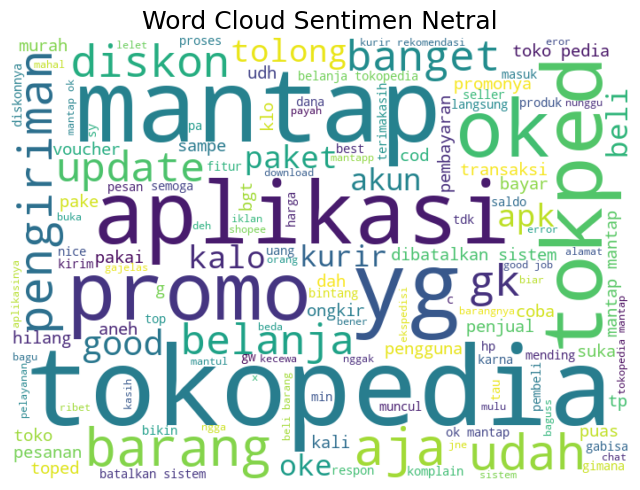

In [19]:
# wordcloud netral
wordcloud(df_data[df_data['sentimen'] == 'netral'], 'Word Cloud Sentimen Netral')

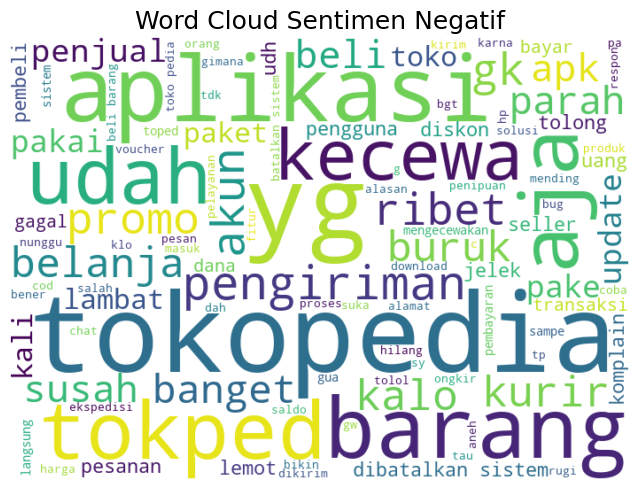

In [20]:
# wordcloud negatif
wordcloud(df_data[df_data['sentimen'] == 'negatif'], 'Word Cloud Sentimen Negatif')

## **DATA SPLITTING**

In [21]:

X = df_data['text_akhir']
y = df_data['sentimen'].map({'positif': 2, 'netral': 1, 'negatif': 0})

In [22]:
# transformasi teks ke vektor angka menggunakan TF-IDF
tfidf = TfidfVectorizer(
    max_features=1000,   
    ngram_range=(1,2)    
)
X_tfidf = tfidf.fit_transform(X)

print(f"Dimensi fitur TF-IDF: {X_tfidf.shape}")

Dimensi fitur TF-IDF: (50000, 1000)


In [23]:
# tokenisasi
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(X)

X_sekuensial = tokenizer.texts_to_sequences(X)
X_padat = pad_sequences(X_sekuensial, maxlen=100)

In [24]:
# jumlah kelas sentimen
jumlah_kelas = len(np.unique(y))
print(f"Jumlah kelas: {jumlah_kelas}")
print(f"Dimensi urutan fitur: {X_padat.shape}")


Jumlah kelas: 3
Dimensi urutan fitur: (50000, 100)


## **MODEL**



- Model 1
    * Representasi Data: Word Embedding
    * Algoritma Pelatihan: GRU
    * Pembagian Data: 70% data latih, 30% data uji
- Model 2
    * Representasi Data: TF-IDF
    * Algoritma Pelatihan: Logistic Regression
    * Pembagian Data: 80% data latih, 20% data uji
- Model 3
    * Representasi Data: TF-IDF
    * Algoritma Pelatihan: Random Forest
    * Pembagian Data: 70% data latih, 30% data uji


### GRU

In [25]:

X_train_gru, X_test_gru, y_train_gru, y_test_gru = train_test_split(
    X_padat, y, test_size=0.2, random_state=42
)


X_train_gru, X_validasi_gru, y_train_gru, y_validasi_gru = train_test_split(
    X_train_gru, y_train_gru, test_size=0.125, random_state=42
)
## 0.125 dari 80% adalah 10% dari 100%
## 70% training 20% data uji 10% validasi

print(f"Total Sampel: {X_train_gru.shape[0]+ X_validasi_gru.shape[0]+X_test_gru.shape[0]} ")
print(f"Training: {X_train_gru.shape[0]} sampel")
print(f"Validation : {X_validasi_gru.shape[0]} sampel")
print(f"Test: {X_test_gru.shape[0]} sampel")

Total Sampel: 50000 
Training: 35000 sampel
Validation : 5000 sampel
Test: 10000 sampel


In [26]:


# Model GRU
model_gru = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),
    SpatialDropout1D(0.4),
    GRU(128, dropout=0.3, recurrent_dropout=0.3),
    Dense(3, activation='softmax')
])

# Compile model
model_gru.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

# ketika val loss tidak membaik akan di berhentikan
callback_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=1,
    restore_best_weights=True
)
# ketika val loss tidak membaik learning rate akan di kurang
callback_lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1
)

# Train the model
riwayat_gru = model_gru.fit(
    X_train_gru, y_train_gru,
    validation_data=(X_validasi_gru, y_validasi_gru),
    epochs=15,
    batch_size=64,
    verbose=1,
    callbacks=[callback_early_stopping, callback_lr_reduction]
)


Epoch 1/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.7397 - loss: 0.5947 - val_accuracy: 0.9386 - val_loss: 0.2268 - learning_rate: 0.0010
Epoch 2/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - accuracy: 0.9330 - loss: 0.2260 - val_accuracy: 0.9466 - val_loss: 0.2024 - learning_rate: 0.0010
Epoch 3/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.9398 - loss: 0.2057 - val_accuracy: 0.9510 - val_loss: 0.1984 - learning_rate: 0.0010
Epoch 4/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - accuracy: 0.9448 - loss: 0.1939 - val_accuracy: 0.9506 - val_loss: 0.1919 - learning_rate: 0.0010
Epoch 5/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - accuracy: 0.9465 - loss: 0.1888 - val_accuracy: 0.9502 - val_loss: 0.1932 - learning_rate: 0.0010


In [27]:
# evaluasi dan visualisasi
akurasi_train = riwayat_gru.history['accuracy']

kerugian_test, akurasi_gru = model_gru.evaluate(X_test_gru, y_test_gru)

print("\nEvaluasi Model LSTM")
print(f"Akurasi training per epoch terakhir: {akurasi_train[-1]:.4f}")
print(f"Akurasi pengujian akhir: {akurasi_gru:.4f}")

y_pred_train_gru = np.argmax(model_gru.predict(X_train_gru), axis=1)
y_pred_gru = np.argmax(model_gru.predict(X_test_gru), axis=1)



313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9431 - loss: 0.2186

Evaluasi Model LSTM
Akurasi training per epoch terakhir: 0.9462
Akurasi pengujian akhir: 0.9462
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step



Evaluasi Model GRU + Word Embedding

Akurasi train: 0.9506
Akurasi test: 0.9462

Klasifikasi:
              precision    recall  f1-score   support

     negatif       0.96      0.87      0.91      1693
      netral       0.93      0.97      0.95      5394
     positif       0.97      0.94      0.95      2913

    accuracy                           0.95     10000
   macro avg       0.95      0.93      0.94     10000
weighted avg       0.95      0.95      0.95     10000



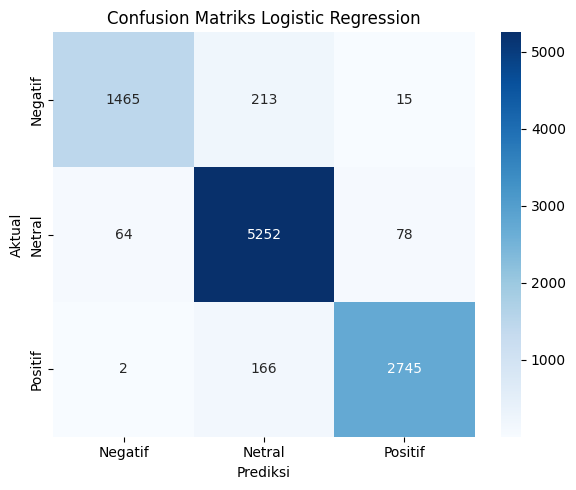

In [28]:
# evaluasi Model
akurasi_train_gru = accuracy_score(y_train_gru, y_pred_train_gru)
akurasi_gru = accuracy_score(y_test_gru, y_pred_gru)
label_kategori = ['Negatif', 'Netral', 'Positif']
print("\nEvaluasi Model GRU + Word Embedding")
print(f'\nAkurasi train: {akurasi_train_gru:.4f}')
print(f'Akurasi test: {akurasi_gru:.4f}')

print("\nKlasifikasi:")
print(classification_report(y_test_gru, y_pred_gru, target_names=['negatif', 'netral', 'positif']))

# confusion matriks
plt.figure(figsize=(6, 5))
cm_gru = confusion_matrix(y_test_gru, y_pred_gru)
sns.heatmap(cm_gru, annot=True, fmt="d", cmap="Blues", xticklabels=label_kategori, yticklabels=label_kategori)

plt.title('Confusion Matriks Logistic Regression')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.tight_layout()
plt.show()

### LOGISTIC REGRESSION

In [29]:
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

print("Total Sampel:")
print(f"Set training: {X_train_lr.shape[0]} sampel")
print(f"Set pengujian: {X_test_lr.shape[0]} sampel")

Total Sampel:
Set training: 40000 sampel
Set pengujian: 10000 sampel


In [30]:
model_lr = LogisticRegression()

model_lr.fit(X_train_lr, y_train_lr)
y_pred_train_lr=model_lr.predict(X_train_lr)
y_pred_lr = model_lr.predict(X_test_lr)


Evaluasi Model Logistic Regression + TF-IDF

Akurasi train: 0.9182
Akurasi test: 0.9052

Klasifikasi:
              precision    recall  f1-score   support

     negatif       0.87      0.80      0.84      1693
      netral       0.90      0.94      0.92      5394
     positif       0.94      0.90      0.92      2913

    accuracy                           0.91     10000
   macro avg       0.90      0.88      0.89     10000
weighted avg       0.91      0.91      0.90     10000



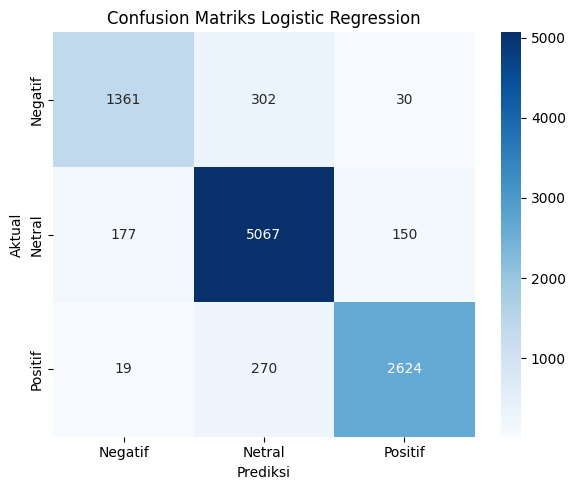

In [31]:
# evaluasi Model
akurasi_train_lr = accuracy_score(y_train_lr, y_pred_train_lr)
akurasi_lr = accuracy_score(y_test_lr, y_pred_lr)

print("\nEvaluasi Model Logistic Regression + TF-IDF")
print(f'\nAkurasi train: {akurasi_train_lr:.4f}')
print(f'Akurasi test: {akurasi_lr:.4f}')

print("\nKlasifikasi:")
print(classification_report(y_test_lr, y_pred_lr, target_names=['negatif', 'netral', 'positif']))

# confusion matriks
plt.figure(figsize=(6, 5))
cm_lr = confusion_matrix(y_test_lr, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", xticklabels=label_kategori, yticklabels=label_kategori)

plt.title('Confusion Matriks Logistic Regression')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.tight_layout()
plt.show()

### RANDOM FOREST

In [32]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_tfidf, y, test_size=0.3, random_state=21)
print("Jumlah Sampel: ")
print(f"Set train: {X_train_rf.shape[0]} sampel")
print(f"Set test: {X_test_rf.shape[0]} sampel")

Jumlah Sampel: 
Set train: 35000 sampel
Set test: 15000 sampel


In [33]:
# inisialisasi dan pelatihan
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

rf_model.fit(X_train_rf, y_train_rf)
y_pred_train_rf=rf_model.predict(X_train_rf)
y_pred_rf = rf_model.predict(X_test_rf)


Evaluasi Model Random Forest dengan TF-IDF
Akurasi train: 0.9489
Akurasi test: 0.8996

Klasifikasi:
              precision    recall  f1-score   support

     negatif       0.85      0.82      0.83      2562
      netral       0.91      0.93      0.92      8030
     positif       0.92      0.90      0.91      4408

    accuracy                           0.90     15000
   macro avg       0.89      0.88      0.88     15000
weighted avg       0.90      0.90      0.90     15000



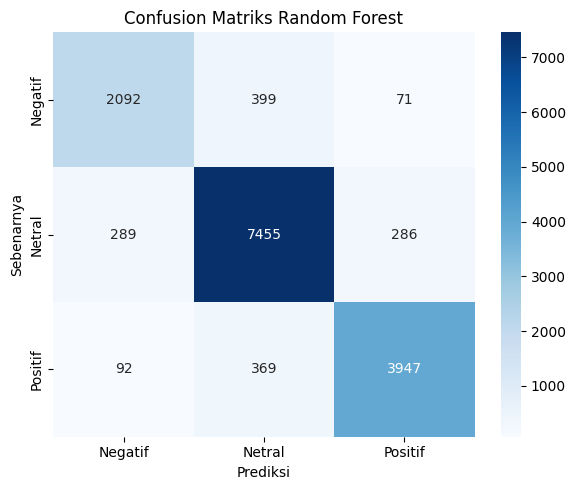

In [34]:
# evaluasi Model
akurat_train = accuracy_score(y_train_rf, y_pred_train_rf)
akurat_test_rf = accuracy_score(y_test_rf, y_pred_rf)

print("\nEvaluasi Model Random Forest dengan TF-IDF")
print(f"Akurasi train: {akurat_train:.4f}")
print(f"Akurasi test: {akurat_test_rf:.4f}")

print("\nKlasifikasi:")
print(classification_report(y_test_rf, y_pred_rf, target_names=['negatif', 'netral', 'positif']))

plt.figure(figsize=(6, 5))
cm_rf = confusion_matrix(y_test_rf, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=label_kategori, yticklabels=label_kategori)

plt.title('Confusion Matriks Random Forest')
plt.xlabel('Prediksi')
plt.ylabel('Sebenarnya')
plt.tight_layout()
plt.show()

In [35]:
# perbandingan
perbandingan = {
    'Model': ['GRU + Embedding (70/30)', 'Logistic Regression + TF-IDF (80/20)', 'Random Forest + TF-IDF (70/30)'],
    'Akurasi': [akurasi_gru, akurasi_lr, akurat_test_rf],
    'Rasio Pembagian Data': ['80/20', '80/20', '70/30'],
    'Jenis Fitur': ['Word Embedding', 'TF-IDF', 'TF-IDF']
}

df_perbandingan = pd.DataFrame(perbandingan)

df_perbandingan['Akurasi'] = df_perbandingan['Akurasi'].apply(lambda x: f"{x:.2%}")

print("Perbandingan Hasil Evaluasi Model")
display(df_perbandingan)

Perbandingan Hasil Evaluasi Model


,Model,Akurasi,Rasio Pembagian Data,Jenis Fitur
0,GRU + Embedding (70/30),94.62%,80/20,Word Embedding
1,Logistic Regression + TF-IDF (80/20),90.52%,80/20,TF-IDF
2,Random Forest + TF-IDF (70/30),89.96%,70/30,TF-IDF


In [36]:
# Simpan model LSTM
model_gru.save("model/gru_model.h5")

# Simpan model Logistic Regression
with open("model/lr_model.pkl", "wb") as f:
    pickle.dump(model_lr, f)

# Simpan model Random Forest
with open("model/rf_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

# Simpan TF-IDF vectorizer
with open("model/vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

# Simpan tokenizer
with open("model/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


## **PREDICT**

In [37]:
# memuat model
gru_model = tf.keras.models.load_model("model/gru_model.h5")

with open("model/lr_model.pkl", "rb") as f:
    lr_model = pickle.load(f)

with open("model/rf_model.pkl", "rb") as f:
    rf_model = pickle.load(f)

with open("model/vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)

with open("model/tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

In [38]:
# contoh data baru
new_texts = [
    "aplikasinya smooth banget, enak di mata",
    "pelayanan jelek, barang saya rusak",
    "interface berubah mulu"
]
new_texts = pd.Series(new_texts)
new_texts = new_texts.apply(cleaningText)
new_texts = new_texts.apply(casefoldingText)
new_texts = new_texts.apply(fix_slangwords)
new_texts = new_texts.apply(tokenizingText)
new_texts = new_texts.apply(filteringText)
new_texts=new_texts.apply(toSentence)


new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded = pad_sequences(new_sequences, maxlen=100)

new_tfidf = vectorizer.transform(new_texts)

gru_preds = np.argmax(gru_model.predict(new_padded), axis=1)

lr_preds = lr_model.predict(new_tfidf)

rf_preds = rf_model.predict(new_tfidf)

y_map = {0: "negative", 1: "neutral", 2: "positive"}

print("\n===== SENTIMENT PREDICTION RESULTS =====\n")
for i, text in enumerate(new_texts):
    print(f"Text {i+1}:")
    print(f"\"{text}\"\n")
    print("Predictions:")
    print(f"  GRU            : {y_map[gru_preds[i]]}")
    print(f"  Logistic Regression: {y_map[lr_preds[i]]}")
    print(f"  Random Forest      : {y_map[rf_preds[i]]}")
    print("-" * 45 + "\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step

===== SENTIMENT PREDICTION RESULTS =====

Text 1:
"aplikasinya smooth banget enak mata"

Predictions:
  GRU            : positive
  Logistic Regression: positive
  Random Forest      : positive
---------------------------------------------

Text 2:
"pelayanan jelek barang rusak"

Predictions:
  GRU            : negative
  Logistic Regression: negative
  Random Forest      : negative
---------------------------------------------

Text 3:
"interface berubah melulu"

Predictions:
  GRU            : neutral
  Logistic Regression: neutral
  Random Forest      : neutral
---------------------------------------------

